In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Install missing libraries
!pip install evaluate -qq

# Transformers and datasets
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    T5ForConditionalGeneration,
    T5Tokenizer,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import evaluate

# LoRA and quantization
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_kbit_training
)
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 1. Dataset Loading and Exploration

Loading the MultiNLI dataset which contains premise-hypothesis pairs across multiple genres with labels: entailment (0), neutral (1), contradiction (2)

In [3]:
# Load MultiNLI dataset
print("Loading MultiNLI dataset from Hugging Face...")
dataset = load_dataset("nyu-mll/multi_nli")

print("\nDataset structure:")
print(dataset)

print("\nTrain set size:", len(dataset['train']))
print("Validation matched size:", len(dataset['validation_matched']))
print("Validation mismatched size:", len(dataset['validation_mismatched']))

# Display sample
print("Sample from training set:")
sample = dataset['train'][0]
for key, value in sample.items():
    print(f"{key:20s}: {value}")

Loading MultiNLI dataset from Hugging Face...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

data/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/4.94M [00:00<?, ?B/s]

data/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/5.10M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})

Train set size: 392702
Validation matched size: 9815
Validation mismatched size: 9832
Sample from training set:
promptID            : 31193
pairID              : 31193n
premise             : Conceptually cream skimming has two basic dimensions - product and g

Exploring genres in MultiNLI...

Genre distribution in training set:
telephone           :  83348 (21.22%)
government          :  77350 (19.70%)
travel              :  77350 (19.70%)
fiction             :  77348 (19.70%)
slate               :  77306 (19.69%)


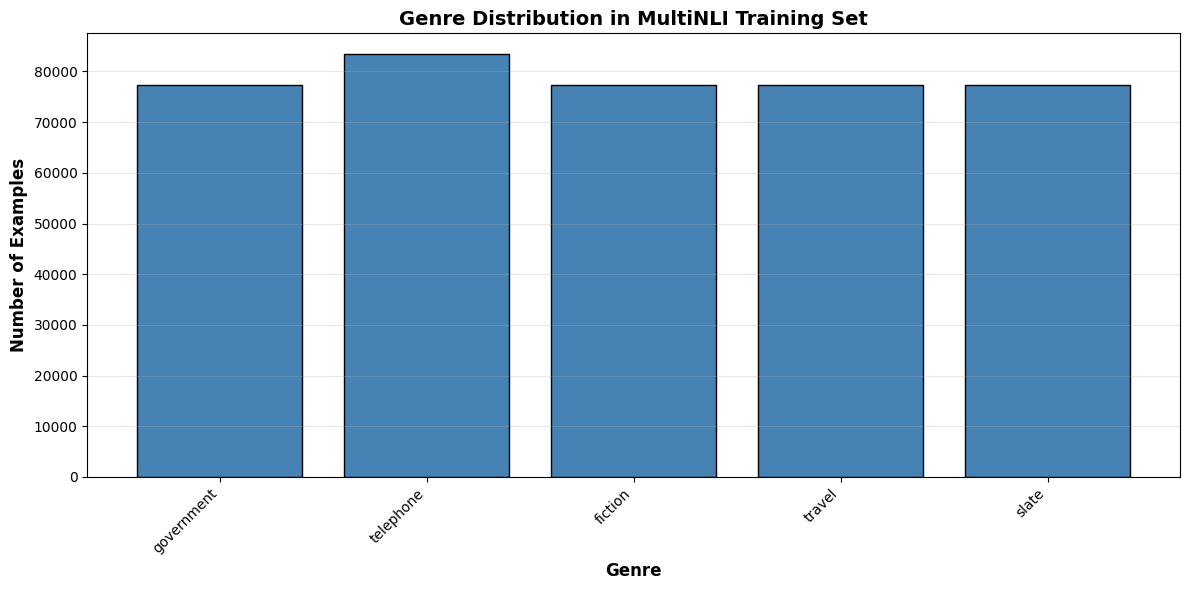

Label distribution in training set:
entailment          : 130899 (33.33%)
neutral             : 130900 (33.33%)
contradiction       : 130903 (33.33%)


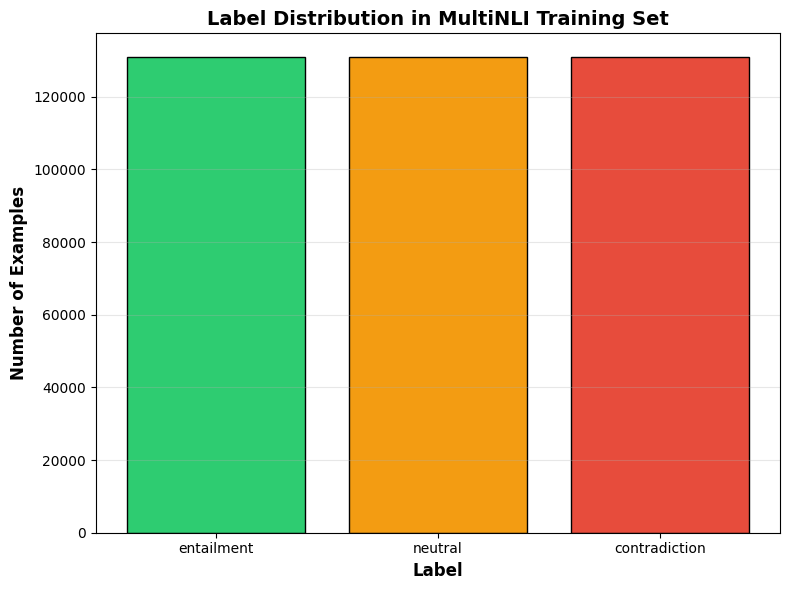

In [4]:
# Explore genres in the dataset
print("Exploring genres in MultiNLI...")

# Extract genres from training set
train_genres = [example['genre'] for example in dataset['train']]
genre_counts = Counter(train_genres)

print("\nGenre distribution in training set:")
print("="*60)
for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{genre:20s}: {count:6d} ({count/len(train_genres)*100:.2f}%)")

# Visualize genre distribution
plt.figure(figsize=(12, 6))
genres = list(genre_counts.keys())
counts = list(genre_counts.values())
plt.bar(genres, counts, color='steelblue', edgecolor='black')
plt.xlabel('Genre', fontsize=12, fontweight='bold')
plt.ylabel('Number of Examples', fontsize=12, fontweight='bold')
plt.title('Genre Distribution in MultiNLI Training Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Label distribution
label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
train_labels = [example['label'] for example in dataset['train']]
label_counts = Counter(train_labels)

print("Label distribution in training set:")
for label, count in sorted(label_counts.items()):
    print(f"{label_map[label]:20s}: {count:6d} ({count/len(train_labels)*100:.2f}%)")

# Visualize label distribution
plt.figure(figsize=(8, 6))
labels = [label_map[l] for l in sorted(label_counts.keys())]
counts = [label_counts[l] for l in sorted(label_counts.keys())]
plt.bar(labels, counts, color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='black')
plt.xlabel('Label', fontsize=12, fontweight='bold')
plt.ylabel('Number of Examples', fontsize=12, fontweight='bold')
plt.title('Label Distribution in MultiNLI Training Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

## 2. Data Preprocessing

Clean and prepare the data for training. Handle missing values, normalize text, and prepare for genre-split experiments.

In [5]:
# Data cleaning and preprocessing
def preprocess_dataset(examples):
    """
    Clean and preprocess the dataset.
    - Remove entries with missing labels (label == -1)
    - Ensure premise and hypothesis are valid strings
    """
    # Filter out invalid labels
    valid_indices = [i for i, label in enumerate(examples['label']) if label != -1]

    return {
        'premise': [examples['premise'][i] for i in valid_indices],
        'hypothesis': [examples['hypothesis'][i] for i in valid_indices],
        'label': [examples['label'][i] for i in valid_indices],
        'genre': [examples['genre'][i] for i in valid_indices]
    }

# Check for missing labels before preprocessing
print("Checking data quality...")
train_invalid = sum(1 for ex in dataset['train'] if ex['label'] == -1)
val_matched_invalid = sum(1 for ex in dataset['validation_matched'] if ex['label'] == -1)
val_mismatched_invalid = sum(1 for ex in dataset['validation_mismatched'] if ex['label'] == -1)

print(f"Train invalid labels: {train_invalid}")
print(f"Validation matched invalid labels: {val_matched_invalid}")
print(f"Validation mismatched invalid labels: {val_mismatched_invalid}")

# Convert to pandas for easier preprocessing
train_df = pd.DataFrame(dataset['train'])
val_matched_df = pd.DataFrame(dataset['validation_matched'])
val_mismatched_df = pd.DataFrame(dataset['validation_mismatched'])

# Filter out invalid labels
print("\nFiltering invalid labels...")
train_df = train_df[train_df['label'] != -1].reset_index(drop=True)
val_matched_df = val_matched_df[val_matched_df['label'] != -1].reset_index(drop=True)
val_mismatched_df = val_mismatched_df[val_mismatched_df['label'] != -1].reset_index(drop=True)

print(f"After filtering - Train: {len(train_df)}, Val Matched: {len(val_matched_df)}, Val Mismatched: {len(val_mismatched_df)}")

# Check for null values
print("\nChecking for null values:")
print(f"Train nulls: {train_df.isnull().sum().sum()}")
print(f"Val matched nulls: {val_matched_df.isnull().sum().sum()}")
print(f"Val mismatched nulls: {val_mismatched_df.isnull().sum().sum()}")

Checking data quality...
Train invalid labels: 0
Validation matched invalid labels: 0
Validation mismatched invalid labels: 0

Filtering invalid labels...
After filtering - Train: 392702, Val Matched: 9815, Val Mismatched: 9832

Checking for null values:
Train nulls: 0
Val matched nulls: 0
Val mismatched nulls: 0
